## Plot results for binary tree

Mamie Wang 2020/10/13



Test run time and accuracy against the length of sequences for binary tree of size 2048. 

Scripts: `sbatch --array = `
List of experiments: `../test_binary_tree.lst`

In [1]:
import pandas as pd
import numpy as np

In [46]:
# write out list of parameters to run

m = [400, 600, 800, 1000, 1200]
tree_type = "binary"
method = ["NJ", "SNJ", "RAxML", 
          "STDR+NJ", "STDR+NJ", "STDR+NJ", 
          "STDR+SNJ", "STDR+SNJ", "STDR+SNJ", 
          "STDR+RAxML", "STDR+RAxML", "STDR+RAxML"]
nrun = 5

size = 2048
path = "None"
threshold = [0] * 15 + list(np.repeat([256, 128, 64] * 3, 5))
kappa = 2
mutation_rate = 0.1
verbose = True
m_lst = np.tile(m, 12)

In [50]:
par_list = pd.DataFrame({"type": tree_type, "method": np.repeat(method, len(m)), 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m_lst, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [53]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_binary_tree.lst", 
                sep = "\t",  index = False)

## Read in the results

In [1]:
def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


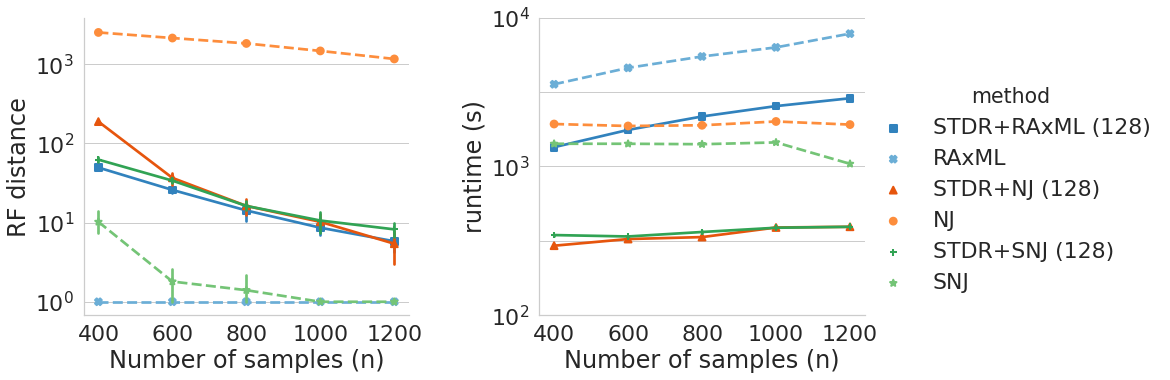

In [2]:
import glob
import pandas as pd
import re
from matplotlib import cm
import matplotlib

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/binary_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (128)", "RAxML", "STDR+NJ (128)","NJ",  "STDR+SNJ (128)", "SNJ"]

selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")


df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] + 1
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

color_dict = dict(zip(ordering, np.array([colors[i] for i in [0,1,4,5,8,9]])))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = ["s", "X", "^", "o", "+", "*"], 
                linestyles=["-", "--", "-", "--", "-", "--"], 
                
                legend_out= True, gridspec_kws={"wspace":0.4})

labels = ["RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    ax.set(yscale="log")
    if i == 1:
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**2.5, 10**3, 10**3.5, 10**4])
    
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)
plt.plot()
plt.savefig("binary_performance.eps")

### reason for not putting the linestyle as well in the legend: https://github.com/mwaskom/seaborn/issues/2005


## Test binary thresholds

In [30]:
# write out list of parameters to run

m = 1000
tree_type = "binary"
method = ["STDR+NJ"] * 5 + \
          ["STDR+SNJ"] * 5 +\
          ["STDR+RAxML"] * 5
nrun = 5

size = 2048
path = "None"
threshold = [32, 64, 128, 256,512] * 3
kappa = 2
mutation_rate = 0.1
verbose = True

In [31]:
par_list = pd.DataFrame({"type": tree_type, "method": method, 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [32]:
par_list

,type,method,nrun,size,path,threshold,m,kappa,mutation_rate,verbose
0,binary,STDR+NJ,5,2048,None,32,1000,2,0.1,True
1,binary,STDR+NJ,5,2048,None,64,1000,2,0.1,True
2,binary,STDR+NJ,5,2048,None,128,1000,2,0.1,True
3,binary,STDR+NJ,5,2048,None,256,1000,2,0.1,True
4,binary,STDR+NJ,5,2048,None,512,1000,2,0.1,True
5,binary,STDR+SNJ,5,2048,None,32,1000,2,0.1,True
6,binary,STDR+SNJ,5,2048,None,64,1000,2,0.1,True
7,binary,STDR+SNJ,5,2048,None,128,1000,2,0.1,True
8,binary,STDR+SNJ,5,2048,None,256,1000,2,0.1,True
9,binary,STDR+SNJ,5,2048,None,512,1000,2,0.1,True


In [75]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_binary_tree_threshold.lst", 
                sep = "\t",  index = False)

In [6]:
paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/binary_m1000*STDR*")

In [1]:
import glob
import pandas as pd
import re
from matplotlib import cm


def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["method", "threshold"], ascend = [True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        #m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        #perf_metrics.loc[:,"m"] = int(m)
        #has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        #perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["method", "threshold"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/binary_m1000*STDR*")
metrics, summarized = summarize_perf(paths)
summarized



runtime             RF            F1      
                         mean     std   mean    std   mean   std
method     threshold                                            
STDR+NJ    32          373.59    3.67   10.0   4.00  99.88  0.05
           64          372.02    3.24   11.6   2.61  99.86  0.03
           128         388.93    3.63    9.2   3.03  99.89  0.04
           256         377.70    6.19   18.8   4.82  99.77  0.06
           512         467.71    2.25  186.0  23.75  97.73  0.29
STDR+RAxML 32         1106.91    5.77    9.6   5.90  99.88  0.07
           64         1546.62    4.08   11.2   3.03  99.86  0.04
           128        2545.03    6.59    7.6   2.19  99.91  0.03
           256        3100.87   26.78    6.8   1.79  99.92  0.02
           512        3462.75  101.96    6.0   3.46  99.93  0.04
STDR+SNJ   32          391.37    2.73   11.6   2.61  99.86  0.03
           64          380.87    7.55   11.6   4.10  99.86  0.05
           128         387.48    3.44    9.6   3.85  99.88  0.05
           256         446.36    3.38    8.0   4.00  99.90  0.05
           512         468.57    4.34    5.2   1.10  99.94  0.01

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


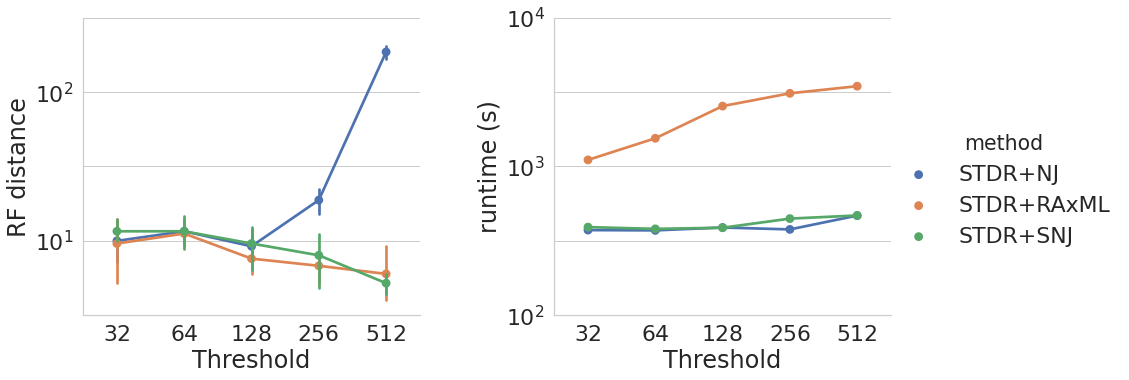

In [9]:
df_long = pd.melt(metrics, id_vars = ["method", "threshold"], var_name = "performance").sort_values(["method", "threshold"])


import numpy as np
#ordering = [ "STDR+RAxML (128)", "RAxML", "STDR+NJ (128)","NJ",  "STDR+SNJ (128)", "SNJ"]

selected = df_long.performance.values != "F1"
df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

#color_dict = dict(zip(ordering, np.array([colors[i] for i in [0,1,4,5,8,9]])))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "threshold", y = "value", hue = "method", col_order = ["RF distance", "runtime (s)"],
           col = "performance", legend = True, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                margin_titles = False, sizes = 20, 
                legend_out= True, gridspec_kws={"wspace":0.4})

labels = ["RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    ax.set(yscale="log")
    if i == 1:
        ax.set(ylim=(0, 3500))
        ax.set_yticks([10**2, 10**2.5, 10**3, 10**3.5, 10**4])
    if i == 0:
        ax.set(ylim=(0, 200))
        ax.set_yticks([10**0.5, 10**1, 10**1.5, 10**2, 10**2.5])

g.set_titles("")
g.set_xlabels("Threshold")
plt.subplots_adjust(wspace = 0.4)
plt.savefig("binary_threshold_performance.eps")

In [2]:
?sns.catplot

Object `sns.catplot` not found.
